In [2]:
import pickle
import boris_extraction as boris
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load collection and create behavior dataframe 

In [3]:
phase2_collection = unpickle_this('phase2collection.pkl')
event_info = {}
is_first = True
sniff_itis = []
total_sniffs = 0
for recording_name, recording in phase2_collection.collection.items():
    for event, events in recording.event_dict.items():
        no_events = events.shape[0]
        sniff_length = 0
        for i in range(len(events)):
            if (event == 'acquisition') and is_first: 
                first_five_min = events[i][0] + 300000
                is_first = False
            if (event == 'acquisition') | (event == 'exposure 0'):
               if events[i][0] < first_five_min:
                   sniff_length_temp = events[i][1] - events[i][0]
                   sniff_length = sniff_length +sniff_length_temp
                   total_sniffs = total_sniffs + 1
               else:
                   pass
            else:
                sniff_length_temp = events[i][1] - events[i][0]
                sniff_length = sniff_length +sniff_length_temp
                total_sniffs = total_sniffs + 1
            try:
                sniff_iti = events[i+1][0] - events[i][1]
                sniff_itis.append(sniff_iti)
            except IndexError:
                pass
        total_sniff_time = sniff_length/1000
        avg_event = sniff_length/no_events/1000
        if (recording_name + recording.subject) in event_info.keys():
            dict_event = event_info[recording_name + recording.subject]
            dict_event[event] =  {'no_events': no_events, 'avg event': avg_event, 'total time': total_sniff_time}
            event_info[recording_name + recording.subject] =  dict_event
        else:
            event_info[recording_name + recording.subject] = {event: {'no_events': no_events, 'avg event': avg_event,'total time': total_sniff_time }}
        
event_info_df = pd.DataFrame.from_dict(event_info)
sniff_itis = np.array(sniff_itis)/1000
sniff_itis 
overlapping_sniffs = 0 
for i in range(len(sniff_itis)):
    if sniff_itis[i] < 4:
        overlapping_sniffs = overlapping_sniffs + 1
print(overlapping_sniffs) # 212 with 5 and 106 with 2 out of 532
print(total_sniffs) #after fixing 0 for 2 out of 424, and 107 for less than 5



262
920


In [4]:
event_overview = pd.concat({k: pd.DataFrame(v) for k, v in event_info.items()}, axis=0)
event_overview = event_overview.reset_index()
event_overview['order'] = ['FCN', 'FCN', 'FCN', 'NFC', 'NFC', 'NFC', 'CNF', 'CNF','CNF', 
                           'FCN', 'FCN', 'FCN', 'NFC', 'NFC','NFC', 'CNF', 'CNF', 'CNF',
                            'FCN','FCN', 'FCN', 'NFC', 'NFC','NFC', 'CNF', 'CNF', 'CNF' ]
no_events = event_overview[event_overview['level_1'] == 'no_events']
FCN_df = event_overview[event_overview['order'] == 'FCN']
CNF_df = event_overview[event_overview['order'] == 'CNF']
NFC_df = event_overview[event_overview['order'] == 'NFC']
event_total_time = event_overview[event_overview['level_1'] == 'total time']
event_total_time_averages = {}
avg_events = []
sem_events = []
for event in ['acquisition', 'recall', 'novel', 'cagemate']:
    avg_event = event_total_time[event].mean()
    sem_event = sem(event_total_time[event])
    event_total_time_averages[event] = avg_event
    avg_events.append(avg_event)
    sem_events.append(sem_event)
avg_events = np.array(avg_events)
sem_events = np.array(sem_events)
event_total_time_averages

{'acquisition': 44.412333333333336,
 'recall': 26.040666666666667,
 'novel': 31.918444444444447,
 'cagemate': 25.66255555555558}

In [5]:
means = event_overview.drop(columns = ['level_0', 'order']).groupby(['level_1']).mean()
agents = ['acquisition', 'recall', 'cagemate', 'novel']
agent_means = means[agents].mean(axis = 1)
agent_means


level_1
avg event      2.474544
no_events     12.972222
total time    32.008500
dtype: float64

# Stats

In [6]:
event_total_time= event_total_time[['recall', 'cagemate', 'novel']]
results = {}
p_values = pd.DataFrame(index=event_total_time.columns, columns=event_total_time.columns)
p_value_list = []
for pair in combinations(event_total_time.columns, 2):
    t_stat, p_value = ttest_rel(event_total_time[pair[0]],event_total_time[pair[1]])
    results[pair] = [t_stat, p_value]
    p_value_list.append(p_value)
            
results


{('recall', 'cagemate'): [0.07207444240623608, 0.9443120028048364],
 ('recall', 'novel'): [-1.618489443544592, 0.14421782849490083],
 ('cagemate', 'novel'): [-0.94038803336199, 0.3745417061226748]}

In [7]:
adjusted_p_values = multipletests(p_value_list, method='holm')
adjusted_p_values

(array([False, False, False]),
 array([0.944312  , 0.43265349, 0.74908341]),
 0.016952427508441503,
 0.016666666666666666)

# Plotting

In [8]:
avg_events = avg_events[np.array([2,1,3])]

sem_events = sem_events[np.array([2,1,3])]

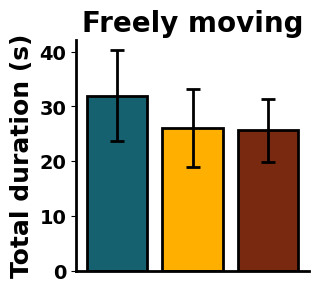

In [13]:
plt.rcParams['font.weight'] = 'bold'  # Set font weight to bold (not bold)
plt.rcParams['axes.titleweight'] = 'bold'  # Set axis title font weight to bold
plt.rcParams['axes.labelweight'] = 'bold'  # Set axis label font weight to bold

color_id_dict = {'novel': hex_2_rgb('#15616F'),  
                'short-term familiar\n(exposure 2)': (1.0, 0.6862745098039216, 0.0),
                'long-term familiar': hex_2_rgb('#792910')
                }
hatches = ['','','']  
plt.figure(figsize= (3,3))           
plt.bar(color_id_dict.keys(), avg_events, yerr = sem_events,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'], linewidth = 2,
            capsize = 5, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
plt.ylabel('Total duration (s)', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Freely moving', fontsize = 20)
plt.savefig('phase2_behavior.png', format='png', dpi=600, transparent = True, bbox_inches='tight')

# Order of exposure EDA

In [10]:
FCN_event_total_time = FCN_df[FCN_df['level_1'] == 'total time']
FCN_event_total_time_averages = {}
for event in ['acquisition', 'recall', 'novel', 'cagemate']:
    avg_event = FCN_event_total_time[event].mean()
    FCN_event_total_time_averages[event] = avg_event
FCN_event_total_time_averages

{'acquisition': 24.08966666666667,
 'recall': 19.433666666666667,
 'novel': 23.544666666666668,
 'cagemate': 21.09866666666667}

In [11]:
NFC_event_total_time = NFC_df[NFC_df['level_1'] == 'total time']
NFC_event_total_time_averages = {}
for event in ['acquisition', 'recall', 'novel', 'cagemate']:
    avg_event = NFC_event_total_time[event].mean()
    NFC_event_total_time_averages[event] = avg_event
NFC_event_total_time_averages

{'acquisition': 26.76466666666667,
 'recall': 17.57766666666667,
 'novel': 21.743,
 'cagemate': 13.132666666666744}

In [12]:
CNF_event_total_time = CNF_df[CNF_df['level_1'] == 'total time']
CNF_event_total_time_averages = {}
for event in ['acquisition', 'recall', 'novel', 'cagemate']:
    avg_event = CNF_event_total_time[event].mean()
    CNF_event_total_time_averages[event] = avg_event
CNF_event_total_time_averages

{'acquisition': 82.38266666666667,
 'recall': 41.11066666666667,
 'novel': 50.467666666666666,
 'cagemate': 42.75633333333334}